In [83]:
from collections import defaultdict
import os
import pickle

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import seaborn as sns
pd.options.display.max_columns = 100
%matplotlib inline

# Ideology Model
This model will use member ideology (dw-nominate scores) from the previous congress, as demonstrated here: https://voteview.com/data
## Feature Construction

In [2]:
# grab ideology data
def concat_ideology(path):
    """Load member ideology scores
    Args:
        path: file path to folder containing files
    
    Returns:
        dataframe and a dictionary
    """
    columns = ['congress', 'bioguide_id', 'dim1', 
               'dim2', 'log_likelihood', 'geo_mean_probability']
    for i, file in enumerate(os.listdir(path)):
        df = pd.read_csv(path + file)
        df = df[columns]
        if i == 0:
            df_m = df
        else:
            df_m = pd.concat([df_m, df])
    df_m.dropna(subset = ['congress', 'bioguide_id'], inplace = True)
    df_m.drop_duplicates(subset = ['congress', 'bioguide_id'], inplace = True)
    
    dict_ideology = defaultdict(dict)
    for i, row in df_m.iterrows():
        key = (int(row.congress), row.bioguide_id)
        value = row.to_dict()
        dict_ideology[key] = value
    
    return df_m, dict_ideology
df_ideology, dict_ideology = concat_ideology('../data/ideology/')

# grab member ids of successful amendments.
df_amendments = pd.read_csv('../data/model/vote_history/amendment_votes_raw.csv')
df_amendments = df_amendments[df_amendments.result.str.contains('Agree')]
df_amendments = pd.DataFrame(df_amendments.groupby('bill_id').member_id.agg(lambda x: list(x)))
df_amendments.rename(columns={0: 'amendment_ids'}, inplace = True)
df_amendments.reset_index(inplace = True)

# pull in bills
df_bills = pd.read_csv('../data/propublica/billsfull_model.csv', encoding = 'latin1')
df_bills.dropna(subset = ['sponsor_id'], inplace = True)
df_bills = pd.merge(df_bills, df_amendments, how = 'left', on = 'bill_id')
def fix_eval(row):
    """Combination of different API pulls from different people resulted in lists being inconsistenly stored
        Also append the sponsor id and ids of members who had a successful ammendment
    """
    try:
        new = eval(row.cosponsor)
        if type(new[0]) == list:
            new = new[0]
    except NameError:
        new = row.cosponsor.replace('[', "")
        new = new.replace(']', "")
        new = new.split(', ')
    except:
        if type(row.cosponsor) == float:
            new = []
        else:
            new = row.cosponsor
    new.append(row.sponsor_id)
    if type(row.amendment_ids) == list:
        for a_id in row.amendment_ids:
            new.append(a_id)
    return set(new)
df_bills['cosponsor_ids'] = df_bills.apply(fix_eval, axis = 1)

# get central tendency stats for cosponsor ideologies
output = []
id_values = ['dim1', 'dim2', 'geo_mean_probability', 'log_likelihood']
for i, row in df_bills.iterrows():
    ideologies = [dict_ideology[(row.session - 1, x)] for x in row.cosponsor_ids]
    ideologies = [x for x in ideologies if x != {}]
    if not ideologies:
        continue
    ideologies = pd.DataFrame(ideologies)
    stats_all = {}
    for id_value in id_values:
        stats = ideologies[id_value].describe()
        stats.index = [id_value + "_" + x for x in stats.index]
        stats = stats.to_dict()
        stats_all = {**stats_all, **stats}
    stats_all['i'] = i
    output.append(stats_all)
stats_all = pd.DataFrame(output)
stats_all = stats_all[[x for x in stats_all.columns if not x.endswith('_count')]]
stats_all = stats_all[[x for x in stats_all.columns if not x.endswith('_std')]]
stats_all.set_index('i', inplace = True)
df_bills = pd.concat([df_bills, stats_all], axis = 1)
df_bills = df_bills[['bill_id'] + stats_all.columns.tolist()]
df_bills.drop_duplicates(subset=['bill_id'], inplace = True)

In [54]:
# votes file
def get_full_set(path):
    for dataset in ['train','dev','test']:
        df = pd.read_csv(path + dataset + '.csv', encoding = 'latin1')
        if dataset == 'train':
            df_votes = df
        else:
            df_votes = pd.concat([df_votes, df])
    return df_votes

df_votes = get_full_set('../data/model/')
df_votes = pd.merge(df_votes, df_bills, on = 'bill_id', how = 'left')
df_ideology.rename(columns = {'congress': 'congress_real', 'bioguide_id': 'member_id'}, inplace = True)
df_ideology['congress'] = df_ideology.congress_real + 1
df_votes = pd.merge(df_votes, df_ideology, how = 'left', on = ['member_id', 'congress'])
df_votes.dropna(subset = ['dim1_25%', 'dim1'], inplace = True)
cols = [x for x in df_bills.columns if x != 'bill_id']
cols += ['full_set_id']
cols += df_ideology.columns.tolist()
df_votes = df_votes[cols]
df_votes.to_csv('../data/model/ideology/features1.csv')

## Model

In [75]:
test = pd.read_csv('../data/model/test.csv')
train = pd.read_csv('../data/model/train.csv')
dev = pd.read_csv('../data/model/dev.csv')
dfs = [train, dev, test]
def join_features(df):
    df = pd.merge(df, df_votes, on = 'full_set_id', how = 'left').dropna(subset = ['dim1_25%', 'dim1', 'log_likelihood'])
    return df
model_train, model_dev, model_test =  map(join_features, dfs)

In [76]:
# baseline if randomly assign 1 at level proportional to overall rate
t = [1] * int(len(model_dev) * model_train.broke_from_party.mean())
t += ([0] *(len(model_dev) - len(t)))
t = shuffle(t)
print(metrics.classification_report(model_dev['broke_from_party'], t, digits=4))

             precision    recall  f1-score   support

          0     0.9446    0.9440    0.9443    375934
          1     0.0550    0.0556    0.0553     22041

avg / total     0.8953    0.8948    0.8951    397975



In [78]:
features = [x for x in cols if x not in ['full_set_id', 'congress', 'congress_real', 'member_id']]
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=200)
rfc.fit(model_train[features], model_train['broke_from_party'])
model_dev[features].head(1)

,dim1_25%,dim1_50%,dim1_75%,dim1_max,dim1_mean,dim1_min,dim2_25%,dim2_50%,dim2_75%,dim2_max,dim2_mean,dim2_min,geo_mean_probability_25%,geo_mean_probability_50%,geo_mean_probability_75%,geo_mean_probability_max,geo_mean_probability_mean,geo_mean_probability_min,log_likelihood_25%,log_likelihood_50%,log_likelihood_75%,log_likelihood_max,log_likelihood_mean,log_likelihood_min,dim1,dim2,log_likelihood,geo_mean_probability
0,-0.60675,-0.5555,-0.50425,-0.453,-0.5555,-0.658,-0.37925,-0.2465,-0.11375,0.019,-0.2465,-0.512,0.898913,0.905675,0.912438,0.9192,0.905675,0.89215,-96.437578,-91.194935,-85.952292,-80.70965,-91.194935,-101.68022,-0.31,-0.205,-87.35178,0.912


C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


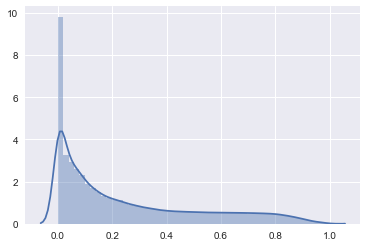

In [79]:
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [81]:
thresh = .78
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

22493
             precision    recall  f1-score   support

          0     0.9669    0.9657    0.9663    375934
          1     0.4267    0.4355    0.4310     22041

avg / total     0.9369    0.9363    0.9366    397975



In [84]:
def export_predictions(dfs, model, file_name, 
                       path = "../data/model/model_predictions/", 
                       predictors = features):
    """Exports probabilities for all sets
    Args:
        dfs: train, dev, test sets. in that order.
        model: sklearn model to get predictions
        path: where to export
        predictors: Column set to use as predictors
    """
    labels = ['train', 'dev', 'test']
    for label, df in zip(labels, dfs):
        probs = model.predict_proba(df[predictors])[:,1]
        probs = pd.DataFrame(probs, index = df.full_set_id, columns=['pred_probs'])
        probs.to_csv(path + file_name + "_" + label + ".csv")

with open('../data/model/ideology/rfc_ideology.pickle', 'wb') as f:
    pickle.dump(rfc, f)
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, rfc, 'ideology', predictors=features)